In [8]:
import sys
import os

sys.path.insert(0, os.path.abspath(".."))

import torch
from tool.darknet2pytorch import Darknet
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from cfg.train.cfg_yolov4_BEV_dist_nuScenes import Cfg as cfg

# check for cuda
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

# params
cfg.weights = "../checkpoints/Yolo_BEV_dist_nuScenes_epoch43__BESTSOFAR.pth"
cfg.dataset_dir = "../../data/nuScenes/"
cfg.cfgfile = "../cfg/model/yolov4_BEV_dist_nuScenes.cfg"

img_paths = []
with open(os.path.join(cfg.dataset_dir, "splits", "test_split.txt")) as f:
    for line in f:
        img_paths.append(line.strip())
        

In [9]:
# remove "model" bug from parallel GPU training
state_dict = torch.load(cfg.weights, map_location=torch.device(device))
if "module" in list(state_dict.keys())[0]:
    state_dict_tmp = {}
    for k in state_dict.keys():
        state_dict_tmp[k[7:]] = state_dict[k]
    state_dict = state_dict_tmp

# model
m = Darknet(cfg.cfgfile, model_type="BEV_dist")
m.load_state_dict(state_dict)
if torch.cuda.device_count() > 1:
    m = torch.nn.DataParallel(m)
m.to(device)
m.eval()
print("Done")

Done


/home/mattia/university/Master_thesis/data/nuScenes/samples/CAM_FRONT/n015-2018-10-08-15-36-50+0800__CAM_FRONT__1538984246912460.jpg


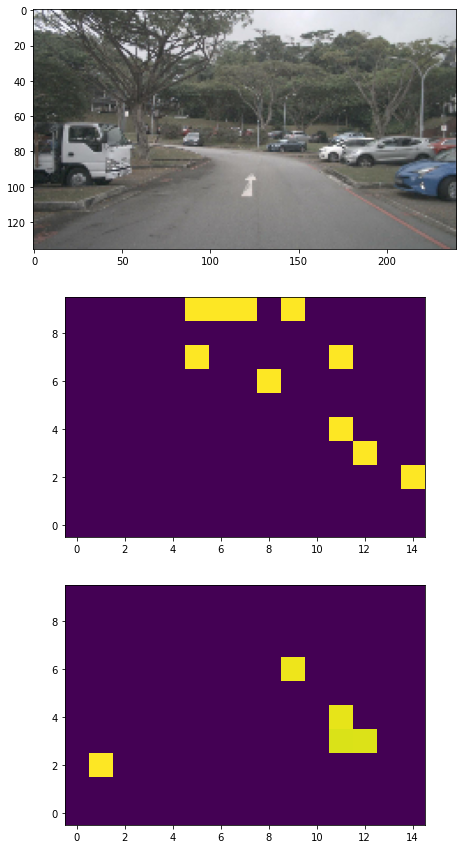

In [12]:
id = 45 # max 8964
threshold = 0.55

# problems 360 - 8050 - 8450

img_path = img_paths[id]  
print(img_path)

############# img retrieval
img = cv2.imread(img_paths[id])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float)
img /= 255.0
img = cv2.resize(img, (cfg.width, cfg.height))

############# get predictions
img_t = torch.Tensor(np.expand_dims(img.transpose(2,0,1), 0))
pred = m(img_t)
pred = pred.detach().cpu().numpy()
pred = pred.transpose().squeeze()
pred = np.where(pred >= threshold, pred, 0.)

############# label retrieval
img_name = img_path.split("/")[-2] + "/" + img_path.strip().split("/")[-1]
column_types = {"ID": str, "alpha": float, "3D_d": float, "3D_l": float, "3D_w": float, "cos": float, "sin": float, "type": str}
df = pd.read_csv(os.path.join(cfg.dataset_dir, "splits", "test_split.csv"), dtype=column_types)
df = df[df["ID"] == img_name]
df["alpha"] += (pred.shape[1] * cfg.cell_angle) / 2   

target = np.zeros(pred.shape)
if not df.empty:
    labels = df[["alpha", "3D_d"]]
    for i, label in labels.iterrows():
        angle_i = int(label["alpha"] // cfg.cell_angle)
        distance_i = int(label["3D_d"] // cfg.cell_depth)
        target[distance_i, angle_i] = 1.0

############## visualization
f, axes = plt.subplots(3,1,figsize=(15,15))
axes[0].imshow(img)
axes[1].imshow(target, origin="lower")
axes[2].imshow(pred, origin="lower")